Here we use ExoMol_to_HITRAN for conversion


python ExoMol_to_HITRAN.py -Q 107.25937 12C-16O Li2015 249.0 33333.4 296.0


In [28]:
%load_ext autoreload
%autoreload 2
from exojax.spec import make_numatrix0,xsvector
from exojax.spec import xsection
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import rtcheck, moldb
import numpy as np
import tqdm
import jax.numpy as jnp
from jax import vmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')
from exojax.spec.exomol import gamma_exomol

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from scipy.constants import Boltzmann, proton_mass, speed_of_light, m_u, Planck
k1=np.float32(Planck*speed_of_light/Boltzmann*1.e2)
k2=np.float32(np.sqrt(Boltzmann/m_u)/speed_of_light) # if T is given
k3=np.float32(1.e-2/speed_of_light/(4.0*np.pi))
print(k1,k2,k3)

1.4387773 3.0415595e-07 2.6544188e-12


In [3]:
import pandas as pd
#Kawashima
dat=pd.read_csv("/home/kawahara/exojax/data/CO/05-1.0E-03bar_1.0E+00.dat",delimiter=",")
#Helios K
datH=pd.read_csv("/home/kawahara/HELIOS-K/Out_i.dat",delimiter="\s",names=("wn","val"))


/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


In [4]:
w=np.array(dat["wav"])*1.e4 #angstrom
wcm=np.array(dat["wav"])*1.e-4 #cm
#subtract Rayleigh scattering
aRay=1.95e-24
absco=dat["absco"]-128.0/3.0*np.pi**5*aRay**2/(wcm**4)

nusH=datH["wn"]
wH=1.e8/nusH #angstrom
absH=datH["val"]

In [5]:
import numpy as np
import astropy.units as u
wls = w[::-1] #
nus = 100000000/wls #cm-1

In [6]:
mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)

In [7]:
dat=pd.read_csv("/home/kawahara/ExoMol_to_HITRAN/ECO.txt",delimiter=",")

In [8]:
mask=dat["S"]>1.e-38

In [20]:
se=np.array((dat["S"][mask]).values,dtype=float)
ne=np.array((dat["nu"][mask]).values,dtype=float)

In [29]:
mdbCOx=moldb.MdbExomol('/home/kawahara/exojax/data/exomol/CO/12C-16O/Li2015/12C-16O__Li2015',nus)

Mol mass= 28.0101
gamma width= 0.07
T exponent= 0.5


In [32]:
mask=mdbCOx.Sij0>1.e-38



(2000, 2300)

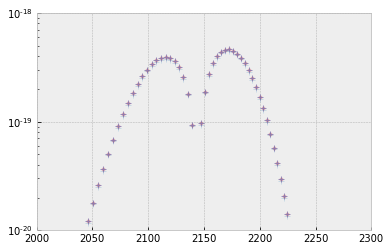

In [50]:
plt.plot(mdbCO.nu_lines,mdbCO.Sij0,"+",alpha=0.2)
plt.plot(ne,se,".",alpha=0.2)
plt.plot(mdbCOx.nu_lines[mask],mdbCOx.Sij0[mask],"+",alpha=0.7)
plt.yscale("log")
plt.ylim(1.e-20,1.e-18)
plt.xlim(2000,2300)

In [9]:
#USE TIPS partition function
Q296=np.array([107.25937215917970,224.38496958496091,112.61710362499998,\
     660.22969049609367,236.14433662109374,1382.8672147421873])
Q1000=np.array([382.19096582031250,802.30952197265628,402.80326733398437,\
2357.1041210937501,847.84866308593757,4928.7215078125000])
qr=Q296/Q1000

In [8]:
qt=np.ones_like(mdbCO.isoid,dtype=np.float64)
for idx,iso in enumerate(mdbCO.uniqiso):
    mask=mdbCO.isoid==iso
    qt[mask]=qr[idx]

In [9]:
Mmol=28.010446441149536
Tref=296.0
Tfix=1000.0
Pfix=1.e-3 #bar

Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)
gammaL = gamma_hitran(Pfix,Tfix,Pfix, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self)
#+ gamma_natural(A) #uncomment if you inclide a natural width
sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)

In [10]:
#check memory size. If the size is large, decrease d.
d=10000
ll=mdbCO.nu_lines+mdbCO.delta_air*Pfix
numatrix=make_numatrix0(nus[0:d],ll)
print("memory size=",numatrix.nbytes/1024/1024,"MB")

memory size= 175.7049560546875 MB


In [11]:
crt=rtcheck.CheckRT() #checker
Ni=int(len(nus)/d)
xsv=[]
for i in tqdm.tqdm(range(0,Ni+1)):
    s=int(i*d);e=int((i+1)*d);e=min(e,len(nus))
    numatrix=make_numatrix0(nus[s:e],ll)
    #numatrix=make_numatrix0(nus[s:e],nu_lines)
    crt.check_hjert(numatrix,sigmaD,gammaL) #checking x, a
    xsv = np.concatenate([xsv,xsvector(numatrix,sigmaD,gammaL,Sij)])

100%|██████████| 331/331 [00:19<00:00,  6.85it/s]


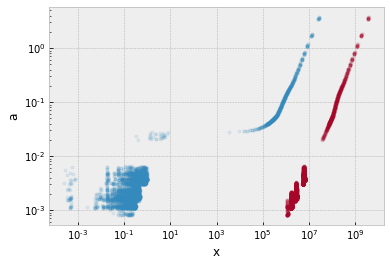

In [12]:
#checking x and a range in H(x,a)
crt.plotxa()

In [12]:
#or just use xsection
xsv=xsection(nus,ll,sigmaD,gammaL,Sij,memory_size=30)

100%|██████████| 1939/1939 [00:13<00:00, 139.87it/s]


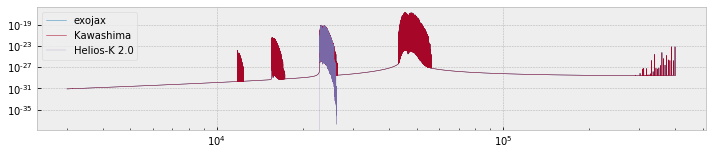

In [13]:
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wls,xsv,lw=0.5,label="exojax")
plt.plot(w,absco,lw=0.5,label="Kawashima")
plt.plot(wH,absH,label="Helios-K 2.0",lw=0.2)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="upper left")
plt.savefig("co_hitran.png")
plt.show()

In [14]:
llow=2300.4
lhigh=2300.7

In [15]:
ii=np.searchsorted(w,wH[0])
iie=ii-len(wH)
wH=np.array(wH)
absHc=absH[::-1]

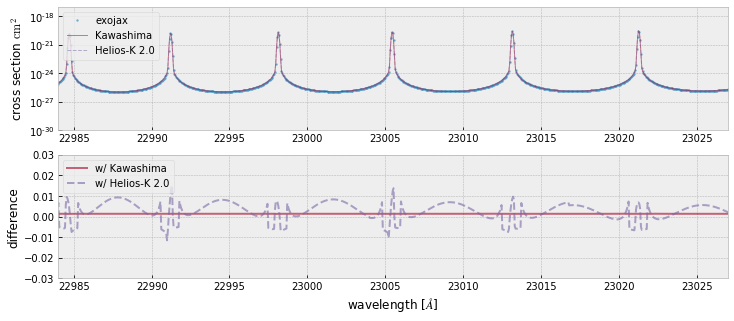

In [16]:
xsvc=xsv[::-1]

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wls,xsv,".",label="exojax",color="C0",markersize=3,alpha=0.5)
plt.plot(w,absco,lw=1.0,label="Kawashima",color="C1",alpha=0.5)
plt.plot(wH,absH,lw=1.0,label="Helios-K 2.0",color="C2",ls="dashed",alpha=0.5)
plt.ylim(1.e-30,1.e-17)
plt.yscale("log")
tip=20.0
plt.xlim(llow*10.0-tip,lhigh*10.0+tip)
plt.legend(loc="upper left")
plt.ylabel("cross section $\mathrm{cm}^{2}$")
ax=fig.add_subplot(212)
plt.plot(w,(xsvc-absco)/absco,alpha=0.6,color="C1",\
          label="w/ Kawashima")
plt.plot(w[iie:ii],(xsvc[iie+1:ii+1]-absHc)/absHc,color="C2",alpha=0.6,\
         ls="dashed",label="w/ Helios-K 2.0")
plt.ylabel("difference")
#for iline in wline:
#    plt.axvline(iline,lw=0.3)
plt.xlim(llow*10.0-tip,lhigh*10.0+tip)
plt.ylim(-0.03,0.03)
plt.xlabel('wavelength [$\AA$]')
#plt.legend()
plt.legend(loc="upper left")
plt.savefig("comparison.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

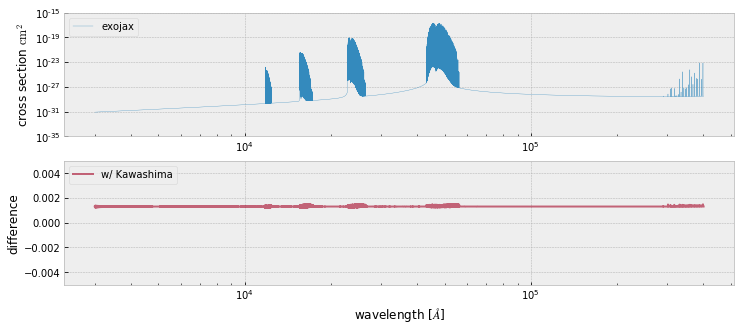

In [17]:
xsvc=xsv[::-1]
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wls,xsv,lw=0.3,label="exojax",color="C0", rasterized=True)
#plt.plot(w,absco,lw=0.5,label="Kawashima",color="C1")
#plt.plot(wH,absH,label="Helios-K 2.0",color="C2")
plt.ylim(1.e-35,1.e-15)
#plt.xlim(50000.0,50300.0)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="upper left")
plt.ylabel("cross section $\mathrm{cm}^{2}$")
ax=fig.add_subplot(212)
plt.plot(w,(xsvc-absco)/absco,alpha=0.6,color="C1",\
          label="w/ Kawashima", rasterized=True)
#plt.plot(w[iie:ii],(absHc-xsvc[iie+1:ii+1])/absHc,color="C2",alpha=0.6,\
#         ls="dashed",label="w/ Helios K-2.0")
plt.ylabel("difference")
#for iline in wline:
#    plt.axvline(iline,lw=0.3)
#plt.xlim(50000.0,50300.0)
plt.ylim(-0.005,0.005)
plt.xlabel('wavelength [$\AA$]')
#plt.legend()
plt.xscale("log")
plt.legend(loc="upper left")
plt.savefig("comparison_wide.pdf", bbox_inches="tight", pad_inches=0.0, dpi=400)
plt.show()

In [21]:
#Checking mass center +- 0.1 cm-1
wline=100000000/mdbCO.nu_lines
xsvc=xsv[::-1]
lw=len(w)
wid=10
xe=[]#center for exojax
xk=[]#center for kawashima
wca=[]
for wc in tqdm.tqdm(wline):
    i=np.searchsorted(w,wc)
    iq=i+wid
    ip=i-wid
    if iq<lw and ip>-1:
        xc_e=np.sum((1.e8/w[ip:iq])*xsvc[ip:iq])/np.sum(xsvc[ip:iq])
        xc_k=np.sum((1.e8/w[ip:iq])*absco[ip:iq])/np.sum(absco[ip:iq])
        xe.append((xc_e-1.e8/wc))
        xk.append((xc_k-1.e8/wc))
        wca.append(wc)
xe=np.array(xe)
xk=np.array(xk)
wca=np.array(wca)

100%|██████████| 4606/4606 [00:01<00:00, 2535.07it/s]


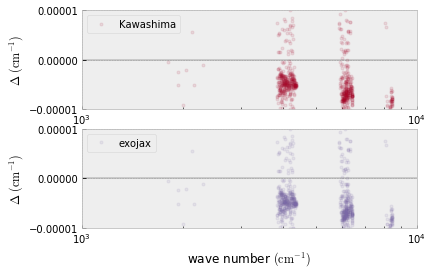

In [22]:
#+- 0.1 cm-1
fig=plt.figure()
ax=fig.add_subplot(211)
plt.plot(1.e8/wca,xk,".",alpha=0.1,color="C1",label="Kawashima")
plt.ylim(-0.00001,0.00001)
plt.xlim(1.e3,1.e4)
#plt.xlim(1.e4,3.e4)
plt.axhline(0.0,color="black",lw=0.3)
plt.ylabel("$\Delta \, \, (\mathrm{cm^{-1}})$")
plt.axhline(0.0002,lw=0.5)
plt.xscale("log")
plt.legend(loc="upper left")
ax=fig.add_subplot(212)
plt.plot(1.e8/wca,xe,".",alpha=0.1,color="C2",label="exojax")
#plt.plot(wca,xk,".")
plt.xscale("log")
plt.ylim(-0.00001,0.00001)
plt.xlim(1.e3,1.e4)
plt.axhline(0.0,color="black",lw=0.3)
plt.ylabel("$\Delta \, \, (\mathrm{cm^{-1}})$")
plt.axhline(0.0002,lw=0.5)
plt.legend(loc="upper left")
plt.xlabel("wave number $(\mathrm{cm}^{-1})$")
plt.savefig("center.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

Don't worry. This trend is just due to pressure shift